<a href="https://colab.research.google.com/github/ThatGuyDV/CNNapproches/blob/master/Age_of_Actors_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://datahack-prod.s3.amazonaws.com/train_zip/train_DETg9GD.zip

--2020-08-01 06:22:59--  https://datahack-prod.s3.amazonaws.com/train_zip/train_DETg9GD.zip
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.64.72
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.64.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50160162 (48M) [application/zip]
Saving to: ‘train_DETg9GD.zip’

train_DETg9GD.zip   100%[===================>]  47.84M  10.4MB/s    in 5.1s    

2020-08-01 06:23:05 (9.46 MB/s) - ‘train_DETg9GD.zip’ saved [50160162/50160162]



In [2]:
%%capture
!unzip train_DETg9GD.zip

In [3]:
!wget https://datahack-prod.s3.amazonaws.com/test_zip/test_Bh8pGW3.zip

--2020-08-01 06:23:16--  https://datahack-prod.s3.amazonaws.com/test_zip/test_Bh8pGW3.zip
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.40
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17007053 (16M) [application/zip]
Saving to: ‘test_Bh8pGW3.zip’

test_Bh8pGW3.zip    100%[===================>]  16.22M  5.28MB/s    in 3.1s    

2020-08-01 06:23:20 (5.28 MB/s) - ‘test_Bh8pGW3.zip’ saved [17007053/17007053]



In [4]:
%%capture
!unzip test_Bh8pGW3.zip

In [6]:
pip install efficientnet_pytorch 

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=3f4d33f63cbc28ad19c736b6d6f2456efbab8c010f11233685b222cb27461c6a
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [63]:
from fastai.vision import *
from fastai.metrics import *
import warnings
warnings.filterwarnings('ignore')
from fastai.callbacks import *
import pandas as pd
import seaborn as sns
from efficientnet_pytorch import EfficientNet

In [8]:
path = Path('/content')

In [9]:
train_df = pd.read_csv(f"{path}/train.csv")
train_df.shape

(19906, 2)

In [11]:
test_df = pd.read_csv(path/'test.csv')
test_df.shape

(6636, 1)

In [12]:
filepath, dirs, files = next(os.walk(f"{path}/Train"))
len(files)

19906

In [14]:
filepath, dirs, files = next(os.walk(f"{path}/Test"))
len(files)

6636

In [15]:
train_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [16]:
train_df.groupby('Class').count()

,ID
Class,
MIDDLE,10804
OLD,2396
YOUNG,6706


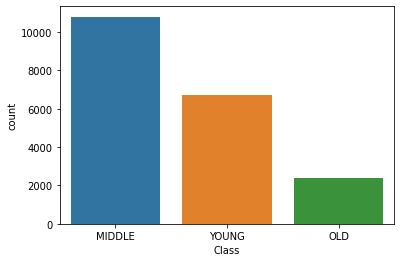

In [17]:
sns.countplot(x='Class' , data=train_df)

In [19]:
test_set = ImageList.from_df(test_df, path=path, folder='Test')

In [20]:
trfm = get_transforms(max_zoom=1.22, max_lighting=0.22, max_warp=0.0)

In [22]:
data = (src.transform(trfm, size=128, padding_mode='reflection', resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
        )

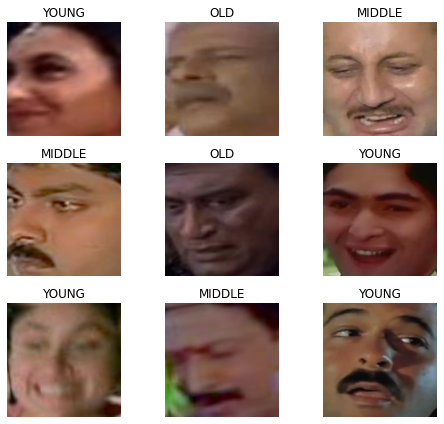

In [23]:
data.show_batch(rows=3, figsize=(7,6))

In [24]:
print(data.classes)
len(data.classes),data.c

['MIDDLE', 'OLD', 'YOUNG']


(3, 3)

In [25]:
len(data.train_ds), len(data.valid_ds)

(17916, 1990)

In [26]:
model_name = 'efficientnet-b3'
def getModel(pret):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features,data.c)
    return model

In [27]:
learn = Learner(data
                ,getModel(True)
                ,metrics=[error_rate, accuracy]
                ,callback_fns = ShowGraph
               )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


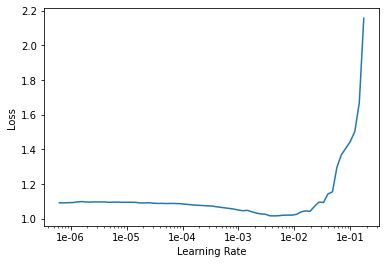

In [28]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.668221,0.607003,0.249749,0.750251,01:39
1,0.511332,0.507228,0.186935,0.813065,01:40
2,0.451436,0.833101,0.276884,0.723116,01:39
3,0.390983,0.602009,0.221106,0.778894,01:38
4,0.333531,0.430016,0.161307,0.838693,01:38
5,0.248262,0.419954,0.169347,0.830653,01:38
6,0.180799,0.318089,0.117085,0.882915,01:38
7,0.109176,0.231399,0.079899,0.920101,01:38
8,0.065119,0.209018,0.068844,0.931156,01:38
9,0.036566,0.211175,0.066834,0.933166,01:38


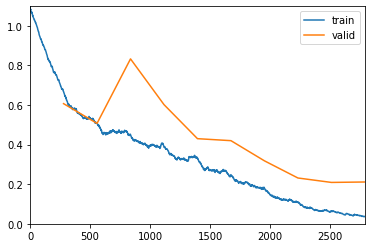

In [29]:
lr = 0.001
learn.fit_one_cycle(10, slice(1e-3), wd=0.2)

In [30]:
learn.save('stage1')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 2.75E-05


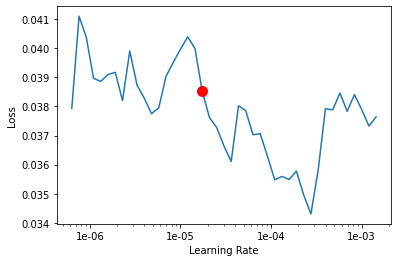

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.039415,0.213479,0.065829,0.934171,01:38
1,0.041925,0.209287,0.062814,0.937186,01:38
2,0.039775,0.219394,0.064322,0.935678,01:38
3,0.035031,0.221905,0.063317,0.936683,01:38
4,0.029765,0.226579,0.062814,0.937186,01:37
5,0.024222,0.230386,0.066332,0.933668,01:37
6,0.022384,0.230693,0.063317,0.936683,01:37
7,0.021954,0.233876,0.064322,0.935678,01:38
8,0.019457,0.232786,0.059799,0.940201,01:38
9,0.017238,0.234789,0.060302,0.939699,01:37


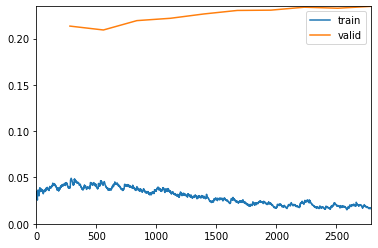

In [32]:
learn.fit_one_cycle(10, slice(5e-05),wd=0.15) 

In [33]:
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.74E-06


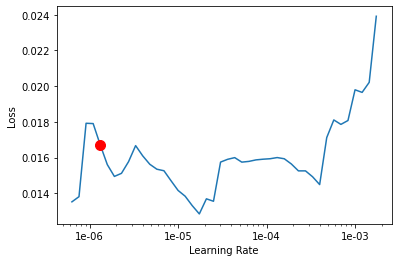

In [35]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.017415,0.231838,0.060302,0.939699,01:38
1,0.015221,0.233134,0.061307,0.938693,01:38
2,0.016516,0.235283,0.059799,0.940201,01:38
3,0.021688,0.235651,0.060302,0.939699,01:38
4,0.021400,0.237215,0.059799,0.940201,01:38
5,0.014942,0.239115,0.059296,0.940704,01:37
6,0.015694,0.236797,0.059296,0.940704,01:37
7,0.015441,0.240579,0.059799,0.940201,01:38
8,0.019653,0.240420,0.058291,0.941709,01:37
9,0.014713,0.239976,0.057789,0.942211,01:37


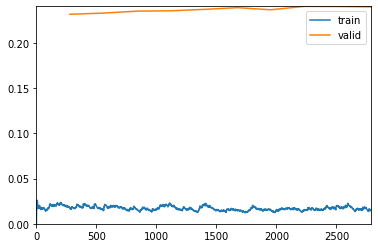

In [36]:
learn.fit_one_cycle(10, slice(1e-5), wd=0.1)

In [40]:
learn.save('stage-3')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-04


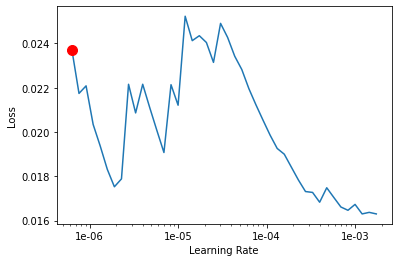

In [41]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.019715,0.250984,0.062312,0.937688,01:37
1,0.025562,0.269938,0.067839,0.932161,01:37
2,0.024535,0.247681,0.067337,0.932663,01:37
3,0.018257,0.261261,0.059799,0.940201,01:37
4,0.014997,0.261191,0.060804,0.939196,01:37


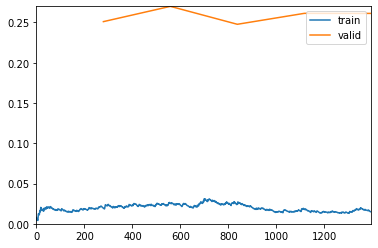

In [42]:
learn.fit_one_cycle(5, slice(1e-4), wd=0.1)

In [43]:

learn.save('stage-4')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-06


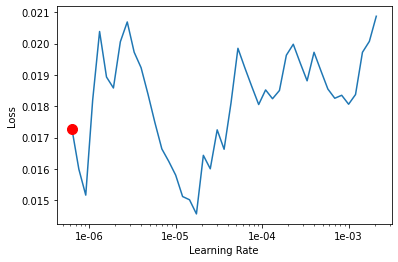

In [44]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion=True)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.011440,0.258048,0.059799,0.940201,01:37
1,0.024295,0.256985,0.059296,0.940704,01:37
2,0.014469,0.250046,0.058291,0.941709,01:37
3,0.011076,0.251268,0.060302,0.939699,01:37
4,0.011423,0.253647,0.060804,0.939196,01:37


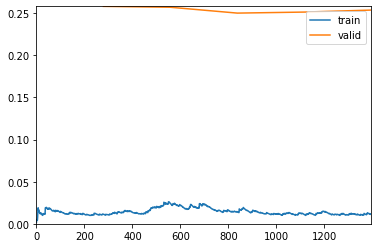

In [45]:
learn.fit_one_cycle(5, slice(7e-5), wd=0.1)

In [47]:
learn.save('stage-5')

In [48]:
interp = ClassificationInterpretation.from_learner(learn)

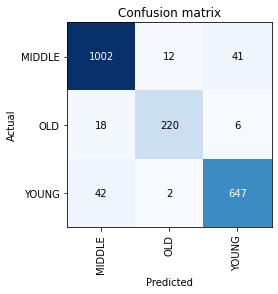

In [49]:
interp.plot_confusion_matrix()

In [50]:

interp.most_confused(min_val=2)

[('YOUNG', 'MIDDLE', 42),
 ('MIDDLE', 'YOUNG', 41),
 ('OLD', 'MIDDLE', 18),
 ('MIDDLE', 'OLD', 12),
 ('OLD', 'YOUNG', 6),
 ('YOUNG', 'OLD', 2)]

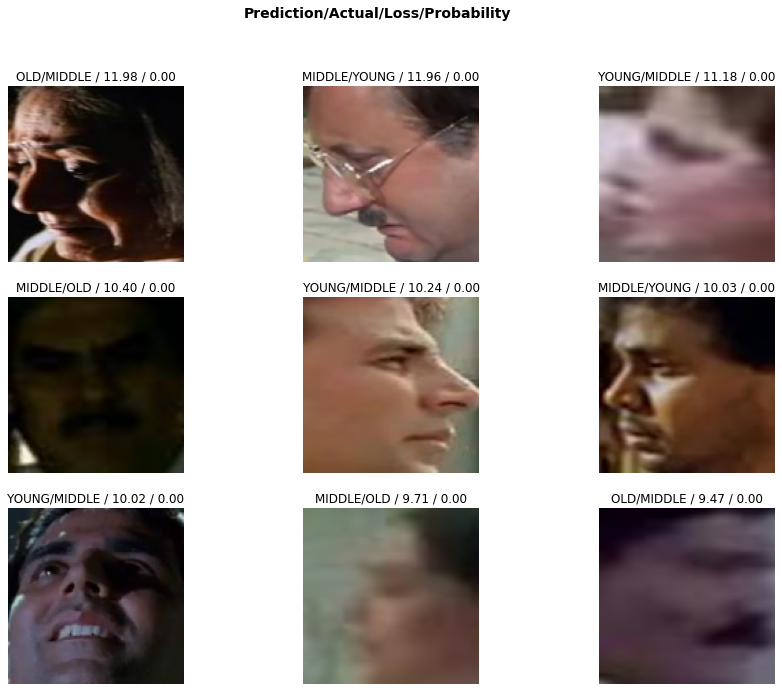

In [51]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [53]:
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y)

0.9412060301507538

In [54]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]

labelled_preds = np.array(labelled_preds)

In [55]:
preds

tensor([[9.9011e-01, 8.8816e-03, 1.0044e-03],
        [7.9056e-06, 8.9529e-06, 9.9998e-01],
        [8.9929e-01, 3.0985e-03, 9.7610e-02],
        ...,
        [9.8905e-01, 1.0951e-02, 3.1628e-07],
        [9.9963e-01, 3.7107e-04, 4.0978e-07],
        [1.0004e-01, 4.0668e-03, 8.9589e-01]])

In [56]:
final = [data.classes[i] for i in np.argmax(preds, axis=1)]

In [57]:
final[:10]

['MIDDLE',
 'YOUNG',
 'MIDDLE',
 'MIDDLE',
 'MIDDLE',
 'MIDDLE',
 'YOUNG',
 'YOUNG',
 'MIDDLE',
 'MIDDLE']

In [58]:
submission = test_df.copy()

In [60]:
submission["Class"] = final

In [61]:
submission_fm = submission[['Class', 'ID']]
submission_fm

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg
...,...,...
6631,OLD,1876.jpg
6632,MIDDLE,14940.jpg
6633,MIDDLE,3638.jpg
6634,MIDDLE,376.jpg


In [62]:
submission.to_csv(f'{path}/Submission.csv', index=False)